In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import datetime
import pytz

import torchvision.models as models
from torchvision.models import resnet34, ResNet34_Weights
from torchvision import models

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from torchvision import datasets,transforms
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, Dataset,random_split
from skimage import io, transform
import torchvision.transforms as transforms
from torchvision import transforms, utils
from torchvision.datasets import ImageFolder

import torch.optim as optim
tzInfo = pytz.timezone('Asia/Kolkata')
dt = str(datetime.datetime.now(tz=tzInfo))

# CHANGE EVERYTHING TO RESNET 34!!!!!!!!!! (We changed it remember!!)

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
train_images = 1000
test_images = 200

csv_PATH = "/kaggle/input/binary-labels-dr/trainLabels_Binary.csv"
images_PATH = "/kaggle/input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/"

# Data Part

In [4]:
import torchvision.transforms as transforms

c_trans = transforms.Compose([ # For ImageFolder
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
])


d_trans = transforms.Compose([ # For the dataset class
    transforms.ToPILImage(), ## WE NEED THIS OR ELSE IT GIVES TYPE ERROR WITH NUMPY NDARRAY
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [5]:
cropped_new_df = pd.read_csv(csv_PATH)
cropped_new_df.head()

,Unnamed: 0,image,level
0,0,10_left,0
1,1,10_right,0
2,2,13_left,0
3,3,13_right,0
4,5,15_right,1


In [6]:
x = [a for a in cropped_new_df["level"]]
np.unique(np.array(x))

array([0, 1])

In [7]:
import torch
from PIL import Image

class retinaDataset(Dataset):
    def __init__(self, imagepath = images_PATH, start = 0, total = None, transform = None):
        self.df = cropped_new_df
        
        if (total is not None):
            self.df = self.df[start:total]
        
        self.transform = transform
        
        self.imagepath = imagepath
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.imagepath, self.df.iloc[index].image +".jpeg")
        # img = Image.open(img_path) # Old
        img = io.imread(img_path) # New
        img = torch.from_numpy(img).permute(2, 0, 1)
        
        if(self.transform):
            img = self.transform(img)
        
        return img, torch.tensor(self.df.iloc[index].level)

In [8]:
trainset_DS = retinaDataset(total = train_images, transform = d_trans)
testset_DS = retinaDataset(start = train_images, total = train_images + test_images, transform = d_trans)
print(len(trainset_DS))
print(len(testset_DS))
print()
trainloader_DS = DataLoader(dataset=trainset_DS, batch_size = 32, shuffle=True)
testloader_DS = DataLoader(dataset=testset_DS, batch_size = 32, shuffle=True)
print(len(trainloader_DS))
print(len(testloader_DS))

1000
200

32
7


0 torch.Size([3, 224, 224]) tensor(0)
1 torch.Size([3, 224, 224]) tensor(0)
2 torch.Size([3, 224, 224]) tensor(0)
3 torch.Size([3, 224, 224]) tensor(0)


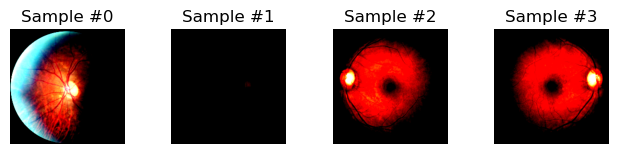

In [9]:
# Verify both sets
mode = "test"
mode = "train"

if mode == "train":
    set = trainset_DS
else:
    set = testset_DS
fig = plt.figure()
limit = 4
for i in range(len(set)):
    img, label = set[i]

    print(i, img.shape, label)

    ax = plt.subplot(1, limit, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(img.permute(1,2,0))
    if i == limit - 1:
        plt.show()
        break

## Attack Part

In [10]:
class Client(nn.Module): # M
    def __init__(self, config):
        super().__init__()
        self.cut_layer = config["cut_layer"]
        
        self.model = resnet34(weights = None)
        self.model = nn.ModuleList(self.model.children())
        self.model = nn.Sequential(*self.model)



    def forward(self, x):
        for i, layer in enumerate(self.model):
            if i > self.cut_layer:
                break
            else:
                x = layer(x)

        return x
    
    
class Server(nn.Module): # M
    def __init__(self, config):
        super().__init__()
        self.logits = config["logits"]
        self.cut_layer = config["cut_layer"]

        self.model = resnet34(weights = None)

        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(nn.Flatten(), nn.Linear(num_ftrs, self.logits))


        self.model = nn.ModuleList(self.model.children()) # These 2 lines help us iterate over the layers (blocks)
        self.model = nn.Sequential(*self.model)


    def forward(self, x):
        for i, layer in enumerate(self.model):
            if i <= self.cut_layer:
                continue
            else:
                x = layer(x)
                
        m = nn.Softmax(dim = 1)

        return m(x)



In [11]:
def reconstruction_loss(img1, img2):
    return nn.L1Loss()(img1, img2)

class ResnetBlock(nn.Module):
    """Define a Resnet block"""

    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Initialize the Resnet block
        A resnet block is a conv block with skip connections
        We construct a conv block with build_conv_block function,
        and implement skip connections in <forward> function.
        Original Resnet paper: https://arxiv.org/pdf/1512.03385.pdf
        """
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Construct a convolutional block.
        Parameters:
            dim (int)           -- the number of channels in the conv layer.
            padding_type (str)  -- the name of padding layer: reflect | replicate | zero
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
            use_bias (bool)     -- if the conv layer uses bias or not
        Returns a conv block (with a conv layer, a normalization layer, and a non-linearity layer (ReLU))
        """
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim), nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x)
        return out


class AdversaryModelGen(nn.Module):
    """ 
    """
    def __init__(self):
        super(AdversaryModelGen, self).__init__()
        input_nc = 512
        output_nc = 3
        ngf = 32
        use_bias = False
        n_blocks = 0
        use_dropout = False
        padding_type = 'reflect'
        norm_layer = nn.BatchNorm2d

        model = [
                    nn.Conv2d(input_nc, ngf, kernel_size=3, padding=1, bias=use_bias),
                    norm_layer(ngf),
                    nn.ReLU(True),
                ]
        n_downsampling = 0

        for i in range(n_downsampling):
            mult = 2 ** i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=use_bias),
                      norm_layer(ngf * mult * 2), nn.ReLU(True)]

        mult = 2 ** n_downsampling
        for i in range(n_blocks):
            model += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]

        for i in range(n_downsampling):  # add upsampling layers
            mult = 2 ** (n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1, bias=use_bias),
                      norm_layer(int(ngf * mult / 2)), nn.ReLU(True)]

        n_upsampling_extra = 4 - n_downsampling 
        for i in range(n_upsampling_extra):
            model += [nn.ConvTranspose2d(ngf, ngf,
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1, bias=use_bias),
                      norm_layer(ngf), nn.ReLU(True)]
            if False and i == 0:
                model += [nn.Conv2d(ngf, ngf,
                                    kernel_size=2, stride=1, padding=0),
                         norm_layer(ngf), nn.ReLU(True)]
        model += [nn.ConvTranspose2d(ngf, output_nc, kernel_size=3, stride=2,
                                     padding=1, output_padding=1, bias=use_bias)]

        self.m = nn.Sequential(*model)

    def forward(self, x):
        for l in self.m:
            x = l(x)
        return x

In [12]:
cut_layer = 7
num_epochs = 20

In [13]:
config = {"cut_layer": cut_layer, "logits": 2}
client_model = Client(config).to(device) # M
server_model = Server(config).to(device) # M
adv_model_attack = AdversaryModelGen().to(device)

criterion = nn.CrossEntropyLoss()
client_optimizer = optim.SGD(client_model.parameters(), lr=0.01, momentum=0.9)
server_optimizer = optim.SGD(server_model.parameters(), lr=0.01, momentum=0.9)
adv_optimizer = optim.SGD(adv_model_attack.parameters(), lr=0.01, momentum=0.9)

In [14]:
mp = "/kaggle/input/saved-models/_Cut_Layer_" + str(cut_layer) + "_1000_images_20_epochs_Client0.pth"
client_model.load_state_dict(torch.load(mp))

<All keys matched successfully>

In [15]:
print(client_model.cut_layer)

7


In [16]:
num_epochs = num_epochs
print(num_epochs, " epochs!")
attack_adv_losses = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader_DS, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        adv_optimizer.zero_grad()

        # Client part
        activations = client_model(inputs)
        server_inputs = activations.detach().clone()

        # Simulation of adversary part is happening in this portion
        server_inputs = Variable(server_inputs, requires_grad=True)
        outputs = adv_model_attack(server_inputs)
        loss = reconstruction_loss(outputs, inputs)
        loss.backward()

        # Adversary's model optimization
        adv_optimizer.step()

        running_loss += loss.item()
        
        if i % 30 == 29:
            print('[{}, {}] loss: {}'.format(epoch + 1, i + 1, running_loss / 30))
            attack_adv_losses.append(running_loss / 30)
            running_loss = 0.0


20  epochs!
[1, 30] loss: 0.9957142154375712
[2, 30] loss: 0.835602714618047
[3, 30] loss: 0.6295545468727748
[4, 30] loss: 0.46794634958108267
[5, 30] loss: 0.42074550688266754
[6, 30] loss: 0.3907770355542501
[7, 30] loss: 0.37628726263840995
[8, 30] loss: 0.35855446656545004
[9, 30] loss: 0.34995748003323873
[10, 30] loss: 0.3365707586208979
[11, 30] loss: 0.33836688498655954
[12, 30] loss: 0.3270454575618108
[13, 30] loss: 0.32084305584430695
[14, 30] loss: 0.3154163579146067
[15, 30] loss: 0.31602753897507985
[16, 30] loss: 0.3015967508157094
[17, 30] loss: 0.30106141716241835
[18, 30] loss: 0.29925954043865205
[19, 30] loss: 0.2904176870981852
[20, 30] loss: 0.2828708072503408


In [17]:
# attack_adv_losses = [0.1458522832393646, 0.12433438271284103, 0.11408672004938125, 0.09359563887119293,
# 0.07783740803599358, 0.0687771338224411, 0.06279803723096848, 0.058749464154243466, 0.05711974740028381,
# 0.05335391491651535, 0.051625465005636216, 0.05129067242145538, 0.05009246677160263, 0.049165113270282744,
# 0.04738562151789665, 0.04835943460464478, 0.0465220282971859, 0.04542914152145386, 0.04559005558490753, 0.04530029907822609]

In [18]:
dataiter = iter(trainloader_DS)
batch = next(dataiter)
images, labels = batch[0].to(device), batch[1].to(device)

## Savings

In [19]:
model_PATH = "/kaggle/working/"
path = model_PATH+"Adversary_Attack_Cut_" + str(cut_layer) + "_" + str(num_epochs) + "_epochs_.pth"
print(path)
torch.save(adv_model_attack.state_dict(), path)

/kaggle/working/Adversary_Attack_Cut_7_20_epochs_.pth


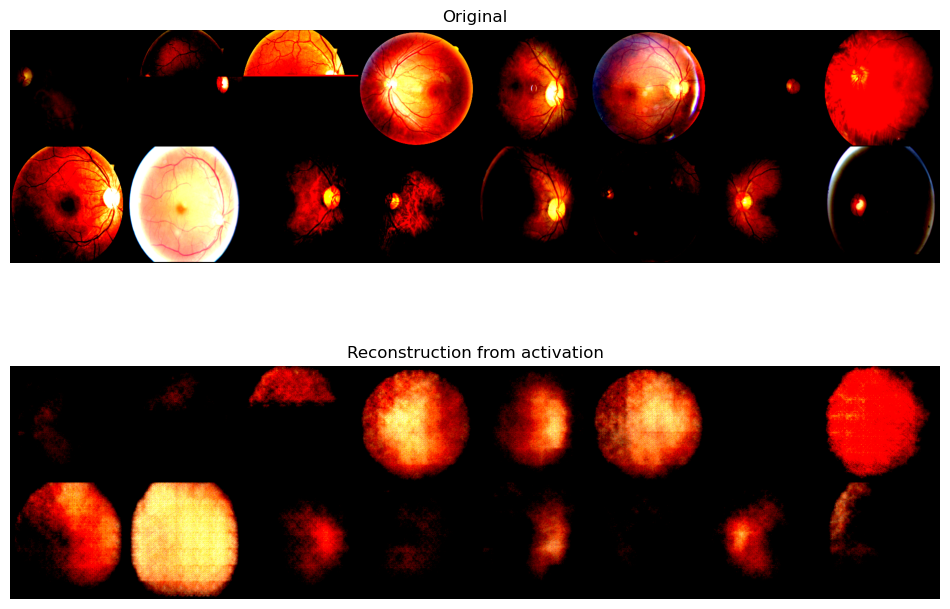

In [20]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

start = 3

axes[0].imshow(torchvision.utils.make_grid(images[start:start+16].cpu()).permute(1, 2, 0))
axes[0].axis("off")
axes[0].title.set_text("Original")

activations = client_model(images).detach()

reconstruction = adv_model_attack(activations).detach()
axes[1].imshow(torchvision.utils.make_grid(reconstruction[start:start+16].cpu()).permute(1, 2, 0))
axes[1].axis("off")
axes[1].title.set_text("Reconstruction from activation")
plt.savefig("/kaggle/working/Reconstruction_Attack_Cut_" + str(cut_layer) + "_" + str(num_epochs) + "_epochs.png")
plt.savefig("/kaggle/working/Reconstruction_Attack_Cut_" + str(cut_layer) + "_" + str(num_epochs) + "_epochs.pdf")

# Defense Part

# The INPUT CHANNELS etc. of ADV MODEL CORRESPOND TO CUT_LAYER 7!!!!!

In [21]:
def reconstruction_loss(img1, img2):
    return nn.L1Loss()(img1, img2)

class ResnetBlock(nn.Module):
    """Define a Resnet block"""

    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Initialize the Resnet block
        A resnet block is a conv block with skip connections
        We construct a conv block with build_conv_block function,
        and implement skip connections in <forward> function.
        Original Resnet paper: https://arxiv.org/pdf/1512.03385.pdf
        """
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Construct a convolutional block.
        Parameters:
            dim (int)           -- the number of channels in the conv layer.
            padding_type (str)  -- the name of padding layer: reflect | replicate | zero
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
            use_bias (bool)     -- if the conv layer uses bias or not
        Returns a conv block (with a conv layer, a normalization layer, and a non-linearity layer (ReLU))
        """
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim), nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x)
        return out


class AdversaryModelGen(nn.Module):
    """ 
    """
    def __init__(self):
        super(AdversaryModelGen, self).__init__()
        input_nc = 512
        output_nc = 3
        ngf = 32
        use_bias = False
        n_blocks = 0
        use_dropout = False
        padding_type = 'reflect'
        norm_layer = nn.BatchNorm2d

        model = [
                    nn.Conv2d(input_nc, ngf, kernel_size=3, padding=1, bias=use_bias),
                    norm_layer(ngf),
                    nn.ReLU(True),
                ]
        n_downsampling = 0

        for i in range(n_downsampling):
            mult = 2 ** i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=use_bias),
                      norm_layer(ngf * mult * 2), nn.ReLU(True)]

        mult = 2 ** n_downsampling
        for i in range(n_blocks):
            model += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]

        for i in range(n_downsampling):  # add upsampling layers
            mult = 2 ** (n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1, bias=use_bias),
                      norm_layer(int(ngf * mult / 2)), nn.ReLU(True)]

        n_upsampling_extra = 4 - n_downsampling 
        for i in range(n_upsampling_extra):
            model += [nn.ConvTranspose2d(ngf, ngf,
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1, bias=use_bias),
                      norm_layer(ngf), nn.ReLU(True)]
            if False and i == 0:
                model += [nn.Conv2d(ngf, ngf,
                                    kernel_size=2, stride=1, padding=0),
                         norm_layer(ngf), nn.ReLU(True)]
        model += [nn.ConvTranspose2d(ngf, output_nc, kernel_size=3, stride=2,
                                     padding=1, output_padding=1, bias=use_bias)]

        self.m = nn.Sequential(*model)

    def forward(self, x):
        for l in self.m:
            x = l(x)
        return x

In [22]:
cut_layer = 7
num_epochs = 20

In [23]:
config = {"cut_layer": cut_layer, "logits": 2}
client_model = Client(config).to(device)
server_model = Server(config).to(device)
adv_model_defense = AdversaryModelGen().to(device)

criterion = nn.CrossEntropyLoss()

client_optimizer = optim.SGD(client_model.parameters(), lr=0.01, momentum=0.9)
server_optimizer = optim.SGD(server_model.parameters(), lr=0.01, momentum=0.9)
adv_optimizer = optim.SGD(adv_model_defense.parameters(), lr=0.01, momentum=0.9)

In [24]:
print(client_model.cut_layer)

7


In [25]:
num_epochs = num_epochs
print(num_epochs, " epochs!")
defense_adv_losses = []
defense_task_losses = []
for epoch in range(num_epochs):
    running_loss_task, running_loss_adv, alpha = 0.0, 0.0, 0.01
    for i, data in enumerate(trainloader_DS, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        client_optimizer.zero_grad()
        server_optimizer.zero_grad()
        
        # Client part
        activations = client_model(inputs)
        server_inputs = activations.detach().clone()
        adv_inputs = activations.detach().clone()
        
        # Simulation of server part is happening in this portion
        # Server part
        server_inputs = Variable(server_inputs, requires_grad=True)
        adv_inputs = Variable(adv_inputs, requires_grad=True)
        outputs = server_model(server_inputs)
        task_loss = criterion(outputs, labels)
        task_loss.backward()

        reconstruction = adv_model_defense(adv_inputs)
        adv_loss = reconstruction_loss(reconstruction, inputs)
        adv_loss.backward()

        # server optimization
        server_optimizer.step()
        adv_optimizer.step()

        # Simulation of Client Happening in this portion
        # Client optimization
        activations.backward(alpha * server_inputs.grad - (1 - alpha) * adv_inputs.grad)
        client_optimizer.step()

        running_loss_task += task_loss.item()
        running_loss_adv += adv_loss.item()
        
        if i % 30 == 29:
            print('[{}, {}] task_loss: {:.4f} adv_loss: {:.4f}'.format(epoch + 1, i + 1,
                                                                       running_loss_task / 30, running_loss_adv / 30))
            defense_adv_losses.append(running_loss_adv / 30)
            defense_task_losses.append(running_loss_task / 30)
            running_loss = 0.0


20  epochs!
[1, 30] task_loss: 0.5311 adv_loss: 0.9963
[2, 30] task_loss: 0.5247 adv_loss: 1.0029
[3, 30] task_loss: 0.5258 adv_loss: 1.2383
[4, 30] task_loss: 0.5226 adv_loss: 1.1326
[5, 30] task_loss: 0.5174 adv_loss: 1.1103
[6, 30] task_loss: 0.5258 adv_loss: 1.1475
[7, 30] task_loss: 0.5237 adv_loss: 1.1217
[8, 30] task_loss: 0.5226 adv_loss: 1.0071
[9, 30] task_loss: 0.5226 adv_loss: 0.9953
[10, 30] task_loss: 0.5237 adv_loss: 1.0097
[11, 30] task_loss: 0.5174 adv_loss: 0.9959
[12, 30] task_loss: 0.5216 adv_loss: 0.9889
[13, 30] task_loss: 0.5247 adv_loss: 0.9842
[14, 30] task_loss: 0.5268 adv_loss: 0.9891
[15, 30] task_loss: 0.5247 adv_loss: 0.9846
[16, 30] task_loss: 0.5237 adv_loss: 0.9861
[17, 30] task_loss: 0.5226 adv_loss: 0.9847
[18, 30] task_loss: 0.5268 adv_loss: 0.9857
[19, 30] task_loss: 0.5226 adv_loss: 0.9840
[20, 30] task_loss: 0.5258 adv_loss: 0.9861


In [26]:
# defense_adv_losses = [0.1562, 0.1553, 0.2045, 0.1690, 0.1622, 0.1521, 0.1734, 0.1763, 0.1479, 0.1482,
#                       0.1478, 0.1479, 0.1478, 0.1475, 0.1475, 0.1479, 0.1478, 0.1477, 0.1476, 0.1477]

# defense_task_losses = [ 0.0793, 0.0787, 0.0779, 0.0792, 0.0789, 0.0787, 0.0789, 0.0781, 0.0779, 0.0792,
#                        0.0784, 0.0779, 0.0784, 0.0767, 0.0786, 0.0790, 0.0781, 0.0778, 0.0789, 0.0779]

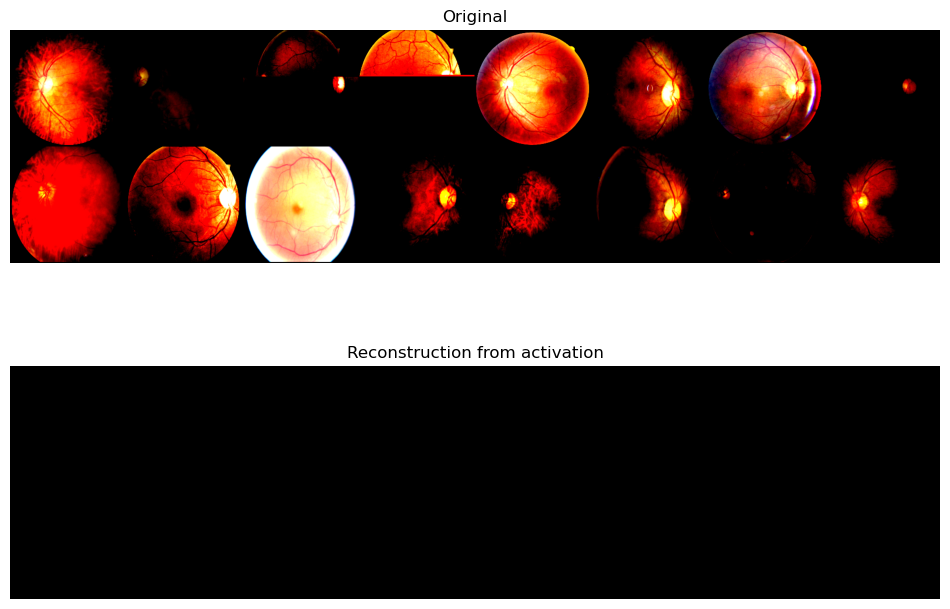

In [27]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

start = 2

axes[0].imshow(torchvision.utils.make_grid(images[start:start+16].cpu()).permute(1, 2, 0))
axes[0].axis("off")
axes[0].title.set_text("Original")

activations = client_model(images).detach()
# channel_index = torch.randint(0, 64, (1,))
# axes[layer_position].imshow(torchvision.utils.make_grid(activations[0:16, channel_index].cpu()).permute(1, 2, 0))
# axes[layer_position].axis("off")
# axes[layer_position].title.set_text("Block number {}, Channel number {}".format(layer_position, channel_index.item()))

reconstruction = adv_model_defense(activations).detach()
axes[1].imshow(torchvision.utils.make_grid(reconstruction[start:start+16].cpu()).permute(1, 2, 0))
axes[1].axis("off")
axes[1].title.set_text("Reconstruction from activation")

plt.savefig("/kaggle/working/Reconstruction_Defense_Cut_" + str(cut_layer) + "_" + str(num_epochs) + "_epochs.png")
plt.savefig("/kaggle/working/Reconstruction_Defense_Cut_" + str(cut_layer) + "_" + str(num_epochs) + "_epochs.pdf")

In [28]:
df = pd.DataFrame()

result = {"Mode":[], "X":[], "Adversarial_Loss":[]}
result["Mode"].append("Attack, Cut 7, 20 epochs")
result["X"].append(list(range(1, 21)))
result["Adversarial_Loss"].append(attack_adv_losses)

result["Mode"].append("Defense, Cut 7, 20 epochs")
result["X"].append(list(range(1, 21)))
result["Adversarial_Loss"].append(defense_adv_losses)

result["Mode"].append("Defense, Task, Cut 7, 20 epochs")
result["X"].append(list(range(1, 21)))
result["Adversarial_Loss"].append(defense_task_losses)

In [29]:
df = pd.DataFrame(result)
df.head()


,Mode,X,Adversarial_Loss
0,"Attack, Cut 7, 20 epochs","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.9957142154375712, 0.835602714618047, 0.6295..."
1,"Defense, Cut 7, 20 epochs","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.9962589581807454, 1.002939260005951, 1.2383..."
2,"Defense, Task, Cut 7, 20 epochs","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.5310780982176463, 0.5247211476167043, 0.525..."


In [30]:
df.to_csv("Adversary_Atk_Def.csv")

In [31]:
list(range(1, 21))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

## Save Results

In [32]:
model_PATH = "/kaggle/working/"
torch.save(client_model.state_dict(), model_PATH+"Client_Defense_Cut_" + str(cut_layer) + "_" + str(num_epochs) + "_epochs_.pth")
torch.save(server_model.state_dict(), model_PATH+"Server_Defense_Cut_" + str(cut_layer) + "_" + str(num_epochs) + "_epochs_.pth")

path = model_PATH + "Adversary_Defense_Cut_" + str(cut_layer) + "_" + str(num_epochs) + "_epochs_.pth"
torch.save(adv_model_defense.state_dict(), path)